# Imports

We first define the set of imports that we will use to preprocess the data.

In [17]:
import torch
import json # for loading the json file

# for tokenizing the sentences
import nltk 
from nltk.tokenize import word_tokenize 
nltk.download('punkt') 

# For visualizing the sentence lengths
import matplotlib.pyplot as plt

# For splitting the dataset into train, validation anmd testing
import random
from sklearn.model_selection import train_test_split

# For creating the dataset class (see the TranslationDataset.py file)
from TranslationDataset import TranslationDataset

[nltk_data] Downloading package punkt to /Users/enzobenoit-
[nltk_data]     jeannin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Preprocessing

We first load the header json file were we store paths / parameters / etc.

In [18]:
# Load the JSON header file
def load_json_header(json_file):
    with open(json_file) as json_data:
        d = json.load(json_data)
        return d

header_file = load_json_header('header.json')

### Functions

We now define the set of functions we will used to preprocess the data. This includes:
- `load_data`: load both the source and target parts of the data
- `build_vocab`: build the vocabulary from the imported source and target data
- `shuffle_and_split`: shuffle and split the data into train, validation and test sets
- `preprocess_datasets`: preprocess the data by applying the above functions




We define a function to load both the source and target parts of the data from files. The file paths are defined in the header json file.

In [19]:
def load_data(source_file_path, target_file_path):
    """
    Load data from two separate files each corresponding to the source and target language.
    Each line in one file corresponds to the translation in the other file. 
    The function returns two lists, one for the source and one for the target language.
    """
    with open(source_file_path, 'r', encoding='utf-8') as file:
        source = file.read().split('\n')
    with open(target_file_path, 'r', encoding='utf-8') as file:
        target = file.read().split('\n')

    # We only keep a certain number of sentences for memory purposes
    # The dataset we use has around 1.5 million sentences for each language
    # The maximum number of sentences is defined in the header file
    source = source[0: min(header_file["max_dataset_size"], len(source))]
    target = target[0: min(header_file["max_dataset_size"], len(target))]

    # Set to lowercase all the sentences in both languages 
    source = [sentence.lower() for sentence in source]
    target = [sentence.lower() for sentence in target]

    return source, target

We then define the function to build the vocabulary from the imported source and target data. We use the nltk tokenizer to tokenize the data and then build the vocabulary from the tokenized data. We also add the special tokens `<pad>`, `<unk>`, `<sos>` and `<eos>` to the vocabulary. These tokens are used to pad the sequences, replace unknown tokens and mark the start and end of the sequences.

In [20]:
def build_vocab(sentences, min_frequency=2, special_tokens=["[UNK]", "[SOS]", "[EOS]", "[PAD]"]):
    """
    Build the vocabulary from the given sentences.
    We use the nltk tokenizer to tokenize the data and then build the vocabulary from the tokenized data.
    We also add the special tokens `<pad>`, `<unk>`, `<sos>` and `<eos>` to the vocabulary. 
    We only add words that appear at least `min_frequency` times in the dataset (default value is 2).
    """
    vocab = {}
    word_counts = {}

    # Initialize vocab with special tokens
    for token in special_tokens:
        vocab[token] = len(vocab)

    # Count word frequencies
    for sentence in sentences:
        for word in word_tokenize(sentence):
            word_counts[word] = word_counts.get(word, 0) + 1

    # Print some examples from the imported dataset
    print("Some tokenized examples:")
    for i in range(5):
        print(word_tokenize(sentences[i]))
        
    # Add words above min frequency to vocab
    for word, count in word_counts.items():
        if count >= min_frequency:
            vocab[word] = len(vocab)

    return vocab

We then define the function to shuffle and split the data into train, validation and test sets. We use the `train_test_split` function from sklearn to split the data into validation and test sets. We then split the validation set into train and validation sets.

In [21]:
def shuffle_and_split(source_sentences, target_sentences, test_size, val_size):
    """
    Shuffle the dataset and split it into train, validation and test sets.
    """
    # Shuffle the datasets in the same order (so that the translation is still correct)
    combined = list(zip(source_sentences, target_sentences))
    random.shuffle(combined)
    shuffled_source_sentences, shuffled_target_sentences = zip(*combined)

    # Splitting into validation and test using the test_size parameter
    src_train_val, src_test, trg_train_val, trg_test = train_test_split(
        shuffled_source_sentences, shuffled_target_sentences, test_size = test_size, random_state =42)
    
    # Splitting the validation sets into train and validation using the val_size parameter 
    src_train, src_val, trg_train, trg_val = train_test_split(
        src_train_val, trg_train_val, test_size = val_size/(1 - test_size), random_state=42)

    return src_train, src_val, src_test, trg_train, trg_val, trg_test

We finally define the function to preprocess the data by applying the above functions. We save the constructed vocabularies and datasets to the corresponding files defined in the header json file.

In [22]:
def decode_tokens(token_ids, vocab):
    """
    Decode a list of token IDs back to a sentence using the vocabulary.

    Args:
        token_ids (list of int): A list of token IDs.
        vocab (dict): A dictionary mapping words to their token IDs.
    
    Returns:
        sentence (str): The decoded sentence.
    """
    # Create a reverse vocabulary
    reverse_vocab = {id: word for word, id in vocab.items()}

    # Decode the token IDs to words
    words = [reverse_vocab.get(id, "[UNK]") for id in token_ids]

    return ' '.join(words)

In [23]:
def preprocess_datasets(source_file_path, target_file_path, save_path):
    """
    Preprocess the datasets and save them to their corresponding files.
    """
    # Load data from source and target files
    source, target = load_data(source_file_path, target_file_path)

    # Check if source and target files have the same number of lines
    if len(source) != len(target):
        raise Exception("Source and target files do not have the same number of examples.")

    # Generate a single plot showing the sentence lengths distribution for both the source and target languages using matplotlib 
    plt.hist([len(word_tokenize(sentence)) for sentence in source], bins=50, label='source')
    plt.hist([len(word_tokenize(sentence)) for sentence in target], bins=50, label='target')
    plt.legend(loc='upper right')
    plt.title('Sentence lengths distribution for both the source and target languages')
    plt.xlabel('Sentence length')
    plt.ylabel('Frequency')
    plt.show()
    

    # We first get the validation and testing set sizes located in the config file
    # We then calculate the training set size from them and the total dataset size (see the shuffle and split function above)
    val_size = header_file["val_size"]
    test_size = header_file["test_size"]

    # Split into train and validation sets, making sure that the source and target sentences are aligned
    src_train, src_val, src_test, trg_train, trg_val, trg_test = shuffle_and_split(source, target, test_size=test_size, val_size=val_size)

    # Check that the source and target datasets have the same size after split, otherwise raise an exception
    if len(src_train) != len(trg_train) or len(src_val) != len(trg_val) or len(src_test) != len(trg_test):
        raise Exception("Source and target datasets do not have the same size")

    # Get the maximum sequence length from the config file
    max_seq_len = header_file["max_seq_len"]
    
    # Build vocab dictionaries for source and target languages using the training sets only 
    source_vocab = build_vocab(src_train)
    target_vocab = build_vocab(trg_train)

    # Create datasets
    # We use the TranslationDataset class defined in the TranslationDataset.py file
    # We pass the source and target datasets, source and target languages, source and target vocabularies, and the sequence length (in the header file)
    train_ds = TranslationDataset(src_train, trg_train, source_vocab, target_vocab, max_seq_len)
    val_ds = TranslationDataset(src_val, trg_val, source_vocab, target_vocab, max_seq_len)
    test_ds = TranslationDataset(src_test, trg_test, source_vocab, target_vocab, max_seq_len)

    # Print an example from the dataset 
    print("One example from the constructed dataset:")
    for i in range(1):
        print(train_ds[i])
        
    # Print dataset sizes as a sanity check
    print("Maximum dataset size:", header_file["max_dataset_size"])
    print("Train dataset size:", len(train_ds))
    print("Validation dataset size:", len(val_ds))
    print("Test dataset size:", len(test_ds))

    # Save the datasets to files
    torch.save(train_ds, save_path + "train_ds.pt")
    torch.save(val_ds, save_path + "val_ds.pt")
    torch.save(test_ds, save_path + "test_ds.pt")

    # Save the vocabularies to files
    torch.save(source_vocab, save_path + "source_vocab.pt")
    torch.save(target_vocab, save_path + "target_vocab.pt")

### Apply preprocessing

Preprocessing english to italian dataset:


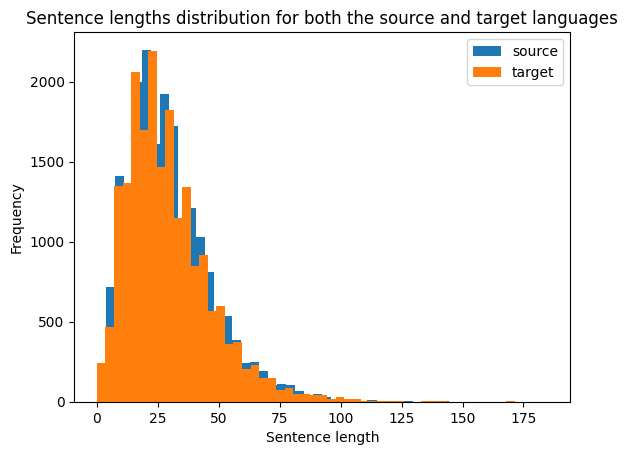

Some tokenized examples:
['she', 'achieved', 'this', 'position', 'totally', 'on', 'her', 'own', 'merit', 'and', 'in', 'open', 'competition', 'against', 'all-comers', '.']
['the', 'commission', 'also', 'agrees', 'with', 'amendment', 'no', '11', ',', 'except', 'for', 'the', 'proposed', 'period', 'of', 'previous', 'employment', 'of', 'only', 'three', 'months', ',', 'as', 'i', 'explained', 'just', 'now', '.']
['i', 'therefore', 'urge', 'this', 'house', 'to', 'reject', 'the', 'full', 'report', 'and', 'let', 'the', 'original', 'commission', 'proposal', ',', 'which', 'was', 'very', 'well-balanced', ',', 'stand', 'unamended', '.']
['we', 'are', 'therefore', 'facing', 'a', 'problem', 'of', 'the', 'first', 'magnitude', ',', 'not', 'only', 'for', 'developing', 'countries', ',', 'but', 'also', 'for', 'the', 'whole', 'planet', 'and', 'all', 'the', 'living', 'beings', 'that', 'inhabit', 'it', ',', 'a', 'problem', 'that', 'parliament', 'has', 'already', 'spoken', 'about', 'at', 'first', 'reading', 'a

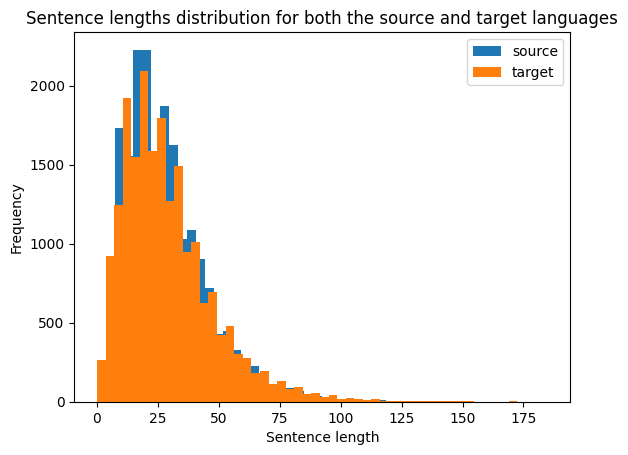

Some tokenized examples:
['the', 'many', 'contradictions', 'and', 'conflicting', 'views', 'over', 'what', 'europe', 'is', 'and', 'the', 'many', 'different', 'legal', 'systems', 'could', 'not', 'only', 'lead', 'to', 'confusion', 'and', 'inefficiency', 'but', 'also', 'create', 'dangerous', 'situations', '.']
['firstly', 'he', 'talked', 'about', 'verification', '.']
['it', 'is', 'also', 'my', 'primary', 'concern', 'to', 'optimise', 'consumer', 'protection', 'in', 'this', 'way', 'and', 'i', 'think', 'it', 'is', 'very', 'important', 'for', 'this', 'to', 'be', 'reflected', 'in', 'the', 'commission', "'", 's', 'proposal', 'and', 'that', 'of', 'the', 'european', 'parliament', ',', 'as', 'well', 'as', 'in', 'the', 'compromise', 'motions', '.']
['in', 'reply', 'to', 'your', 'second', 'point', 'on', 'the', 'court', 'of', 'justice', ',', 'we', 'have', 'not', 'yet', 'established', 'our', 'position', 'on', 'the', 'court', 'of', 'justice', 'because', 'we', 'were', 'waiting', 'for', 'the', 'dur', 'rep

In [24]:
# Preprocess the datasets
print("Preprocessing english to italian dataset:")
preprocess_datasets(header_file['en-it-dataset-english'] , header_file['en-it-dataset-italian'], header_file['en-it-save-path'])

print()
print("Preprocessing english to spanish dataset:")
preprocess_datasets(header_file['en-es-dataset-english'], header_file['en-es-dataset-spanish'], header_file['en-es-save-path'])